In [2]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  #hide any pandas warnings

sns.set(style="whitegrid", color_codes=True)

In [3]:
# Read data
file_name = 'heart.csv'
ds = pd.read_csv(file_name)

In [4]:

# Columns rename
ds.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

# Modifico i valori in modo da identificare con chiarezza le
# feature categoriche
ds['sex'][ds['sex'] == 0] = 'female'
ds['sex'][ds['sex'] == 1] = 'male'

ds['chest_pain_type'][ds['chest_pain_type'] == 1] = 'typical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 2] = 'atypical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 3] = 'non-anginal pain'
ds['chest_pain_type'][ds['chest_pain_type'] == 4] = 'asymptomatic'

ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

ds['rest_ecg'][ds['rest_ecg'] == 0] = 'normal'
ds['rest_ecg'][ds['rest_ecg'] == 1] = 'ST-T wave abnormality'
ds['rest_ecg'][ds['rest_ecg'] == 2] = 'left ventricular hypertrophy'

ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 0] = 'no'
ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 1] = 'yes'

ds['st_slope'][ds['st_slope'] == 1] = 'upsloping'
ds['st_slope'][ds['st_slope'] == 2] = 'flat'
ds['st_slope'][ds['st_slope'] == 3] = 'downsloping'

ds['thalassemia'][ds['thalassemia'] == 1] = 'normal'
ds['thalassemia'][ds['thalassemia'] == 2] = 'fixed defect'
ds['thalassemia'][ds['thalassemia'] == 3] = 'reversable defect'


# Converto i tipi in modo corretto

ds['sex'] = ds['sex'].astype('object')
ds['chest_pain_type'] = ds['chest_pain_type'].astype('object')
ds['fasting_blood_sugar'] = ds['fasting_blood_sugar'].astype('object')
ds['rest_ecg'] = ds['rest_ecg'].astype('object')
ds['exercise_induced_angina'] = ds['exercise_induced_angina'].astype('object')
ds['st_slope'] = ds['st_slope'].astype('object')
ds['thalassemia'] = ds['thalassemia'].astype('object')

In [14]:
# Dataset sample
ds.sample(10)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
75,55,female,typical angina,135,250,lower than 120mg/ml,normal,161,no,1.4,upsloping,0,fixed defect,1
226,62,male,typical angina,120,281,lower than 120mg/ml,normal,103,no,1.4,upsloping,1,reversable defect,0
61,54,male,typical angina,108,309,lower than 120mg/ml,ST-T wave abnormality,156,no,0.0,flat,0,reversable defect,1
40,51,female,atypical angina,140,308,lower than 120mg/ml,normal,142,no,1.5,flat,1,fixed defect,1
182,61,female,0,130,330,lower than 120mg/ml,normal,169,no,0.0,flat,0,fixed defect,0
142,42,female,atypical angina,120,209,lower than 120mg/ml,ST-T wave abnormality,173,no,0.0,upsloping,0,fixed defect,1
87,46,male,typical angina,101,197,greater than 120mg/ml,ST-T wave abnormality,156,no,0.0,flat,0,reversable defect,1
53,44,female,atypical angina,108,141,lower than 120mg/ml,ST-T wave abnormality,175,no,0.6,upsloping,0,fixed defect,1
156,47,male,atypical angina,130,253,lower than 120mg/ml,ST-T wave abnormality,179,no,0.0,flat,0,fixed defect,1
64,58,male,atypical angina,140,211,greater than 120mg/ml,normal,165,no,0.0,flat,0,fixed defect,1


In [15]:
# Shape of dataset
print("Rows:", ds.shape[0], "\nFeatures:", ds.shape[1])

Rows: 303 
Features: 14


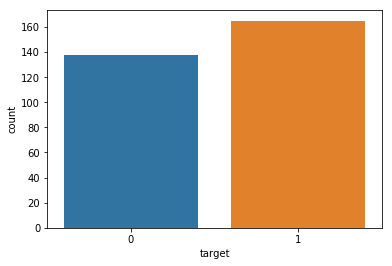

In [4]:
sns.countplot(x=ds['target'])

In [25]:
pd.set_option('display.max_columns', None)
ds.info()
ds.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age                        303 non-null int64
sex                        303 non-null object
chest_pain_type            303 non-null object
resting_blood_pressure     303 non-null int64
cholesterol                303 non-null int64
fasting_blood_sugar        303 non-null object
rest_ecg                   303 non-null object
max_heart_rate_achieved    303 non-null int64
exercise_induced_angina    303 non-null object
st_depression              303 non-null float64
st_slope                   303 non-null object
num_major_vessels          303 non-null int64
thalassemia                303 non-null object
target                     303 non-null int64
dtypes: float64(1), int64(6), object(7)
memory usage: 33.2+ KB


,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.729373,0.544554
std,9.082101,17.538143,51.830751,22.905161,1.161075,1.022606,0.498835
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000,1.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,1.000000


In [29]:
print("There are missing values?", ds.isnull().values.any())

There are missing values? False


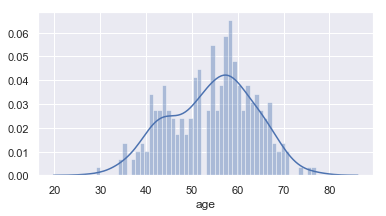

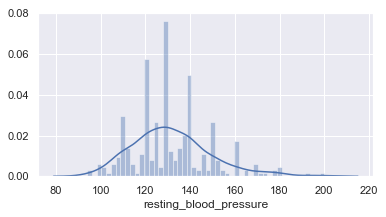

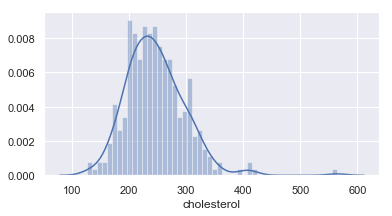

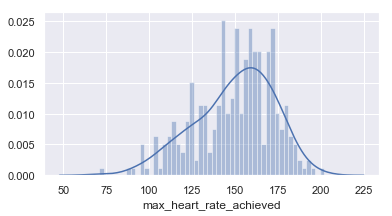

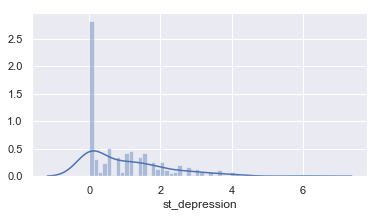

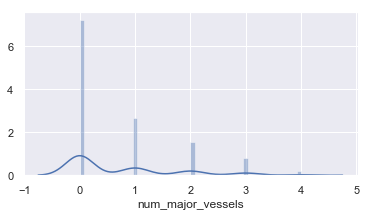

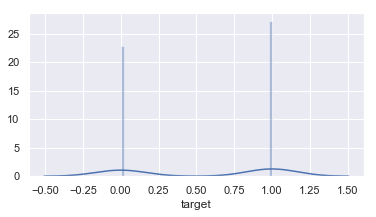

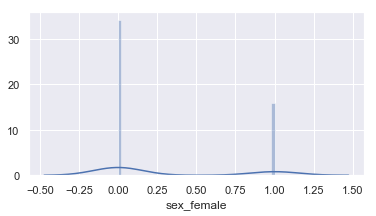

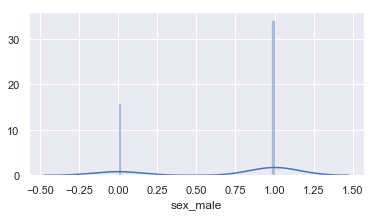

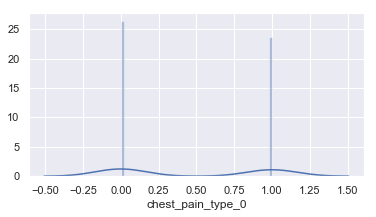

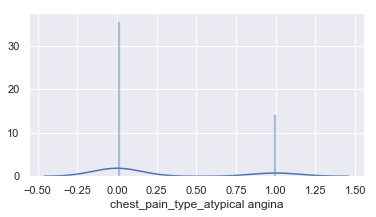

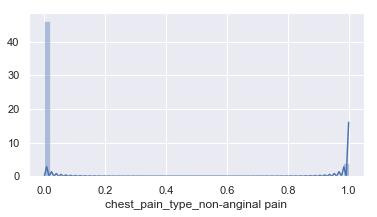

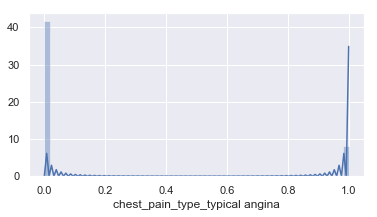

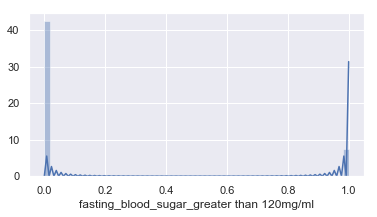

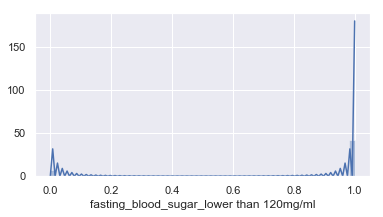

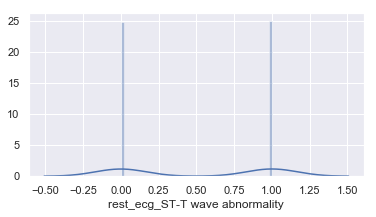

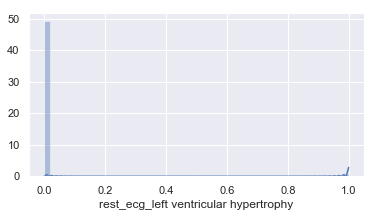

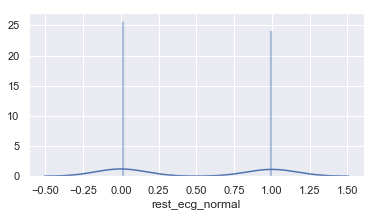

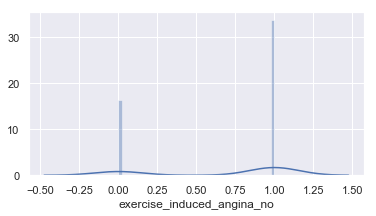

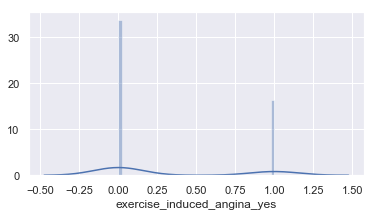

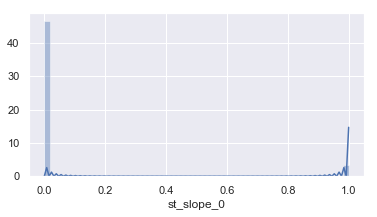

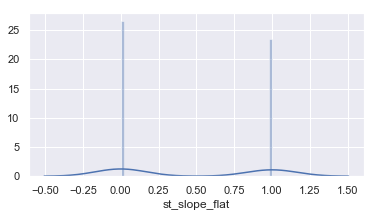

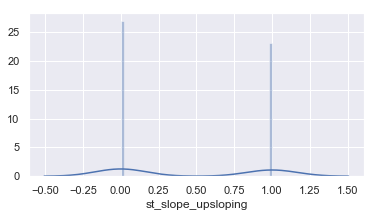

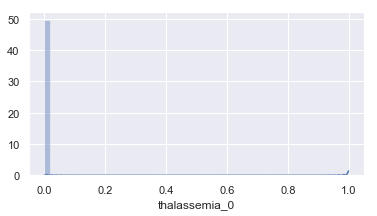

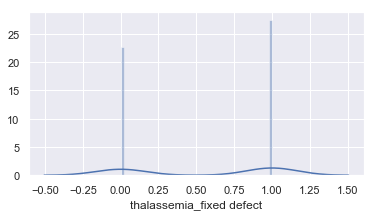

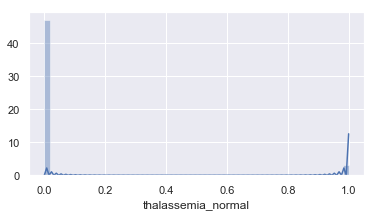

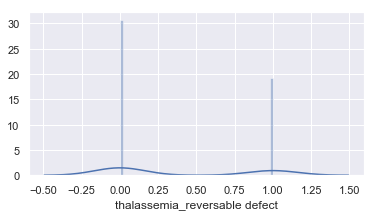

In [24]:
# Dummy features
ds = pd.get_dummies(ds, drop_first=True)
for c in ds.columns:
    plt.figure(figsize=(6, 3))
    sns.distplot(ds[c], hist=True, bins=50)
    plt.show()


In [ ]:
# Altre analisi sui dati

In [89]:
# Split data in dataset and values to predict
X = ds.drop(['target'], axis=1) # X -> data
Y = ds['target'] # Y -> values to predict

(303, 27)


In [56]:
#Uso RFC per estrarre le features più importanti
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state = 50)

model.fit(X, Y)
feature_importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['RFC']).sort_values('RFC', ascending=False)
model = None
feature_importance.head(14)

,RFC
num_major_vessels,0.136503
chest_pain_type_0,0.116112
st_depression,0.095843
cholesterol,0.080936
thalassemia_fixed defect,0.080487
resting_blood_pressure,0.071592
thalassemia_reversable defect,0.070744
max_heart_rate_achieved,0.064982
age,0.062614
exercise_induced_angina_yes,0.058304


In [86]:
# Normalizzo i dati
X_scaled = X

(303, 26)

In [72]:
# Split train set and test set (train: 80% test: 20%)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 50)
print("Train set:", np.round(X_train.shape[0]/X.shape[0]*100), "%")
print("Test set:", np.round(X_test.shape[0]/X.shape[0]*100), "%")

Train set: 80.0 %
Test set: 20.0 %


In [79]:
# First attempt
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state = 50)
model = model.fit(X_train, Y_train)
predict = model.predict(X_test)
accuracy = accuracy_score(Y_test, predict)
accuracy = np.round(accuracy * 100, 3)


print("The accuracy score on the testing set:", accuracy,"%")
print("Hyperparameters values:\n", model.get_params())
model = None

The accuracy score on the testing set: 78.689 %
Hyperparameters values:
 {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 50, 'verbose': 0, 'warm_start': False}


In [111]:
# Hyperparameters tuning

# Definisco le liste di iperparametri
# n_estimators max_depth min_samples_split min_samples_leaf max_features
max_features = list(range(1,X_scaled.shape[1]))
n_estimators = [1, 10, 100, 300, 500, 750, 800, 1200]
n_estimators = [10, 100, 300, 500, 750]
print(n_estimators)
#max_features
# Provo facendo cross validation per ogni valore (o ogni combinazione di valori?)

[10, 100, 300, 500, 750]


In [128]:
from sklearn.model_selection import validation_curve
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = Y_train, 
                                param_name = 'n_estimators', 
                                param_range = n_estimators, cv = 3)
train_scoreNum = [np.mean(line) for line in train_scoreNum]
test_scoreNum = [np.mean(line) for line in test_scoreNum]

In [ ]:
### Print di validation score DA RISCRIVERE PER IL NOSTRO CASO

print(__doc__)

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

digits = load_digits()
X, y = digits.data, digits.target

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), X, y, param_name="gamma", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

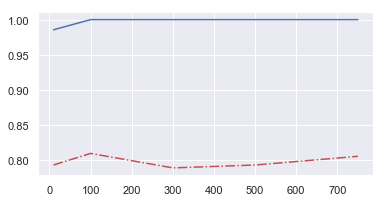

In [131]:
plt.figure(figsize=(6, 3))
plt.plot(n_estimators, train_scoreNum, 'b', label="Train ACC")
plt.plot(n_estimators, test_scoreNum, '-.r', label="Test ACC")
plt.show()